# E313 - Big - G Tracking Code

v2. Yourong Wang, University of Auckland

## Install Required Packages

In [ ]:
!pip3 install --upgrade pip

In [ ]:
!pip3 install scikit-build

In [ ]:
! pip3 install pillow
! pip3 install opencv-python

In [ ]:
!pip3 install imutils

## Importing Packages

In [118]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
%matplotlib inline
import PIL

## Import the Video

Don't forger to change the file name into your own recording.

In [268]:
VidFile = "Cav.mp4"

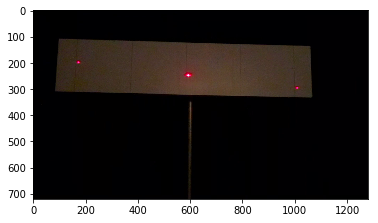

In [269]:
cap = cv2.VideoCapture(VidFile)

ret, image = cap.read()

# The colours might look messed up because OpenCV defaults to BGR 

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

## Parallax Correction
This maps the image of your board to a rectangle.

In [270]:
def perspective_transform(image, corners):
    def order_corner_points(corners):
        # Separate corners into individual points
        # Index 0 - top-right
        #       1 - top-left
        #       2 - bottom-left
        #       3 - bottom-right
        corners = [(corner[0][0], corner[0][1]) for corner in corners]
        top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
        return (top_l, top_r, bottom_r, bottom_l)

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners

    # Determine width of new image which is the max distance between 
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between 
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in 
    # top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                    [0, height - 1]], dtype = "float32")

    # Convert to Numpy format
    ordered_corners = np.array(ordered_corners, dtype="float32")

    # Find perspective transform matrix
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # Return the transformed image
    return cv2.warpPerspective(image, matrix, (width, height))

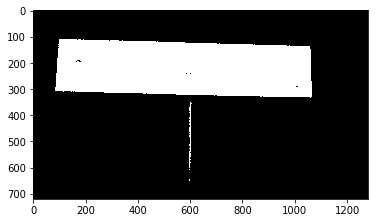

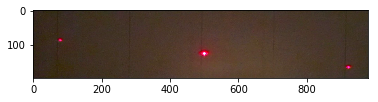

In [291]:
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)
    if len(approx) == 4:
        transformed = perspective_transform(original, approx)

rotated = imutils.rotate_bound(transformed, angle=-90)

plt.figure()
plt.imshow(thresh, cmap = "Greys_r")


plt.figure()
plt.imshow(rotated)

So far, we only worked with the initial frame of our video. Assuming the camera never moved (visibly), we can use the same set of transformations for object tracking! 

This relies on a loop, and will be seen a couple cells down. For now, we need to supply some other tracking information.

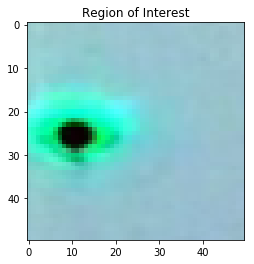

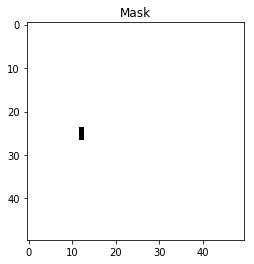

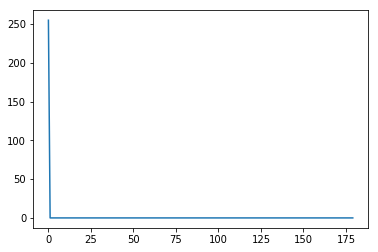

In [327]:
# setup initial guess of tracking window
x, y, w, h = 490, 100, 50, 50 # You need to hard code these ... Initial Guess
track_window = (x, y, w, h)

# visualizing
# inverting the colours seem to do magic!

roi = 255 - rotated[y:y+h, x:x+w]

plt.figure()
plt.imshow(roi)
plt.title("Region of Interest")

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

# Colour Range Detection
Lo = (0,0,0)
Hi = (6,255,255)
   
# Generate Color Mask!
mask = cv2.inRange(hsv_roi, Lo, Hi) # The Mask Color Prefers Red

# Calculate Masked Color Histogram
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

# Plot it 

# You should see a black dot near the middle of a white background!!
plt.figure()
plt.imshow(mask, cmap = "Greys")
plt.title("Mask")

plt.figure()
plt.plot(roi_hist)

## Main Analysis Loop

To see each step in action, please refer to the .py version of the program.

x = 560 @ Frame #60


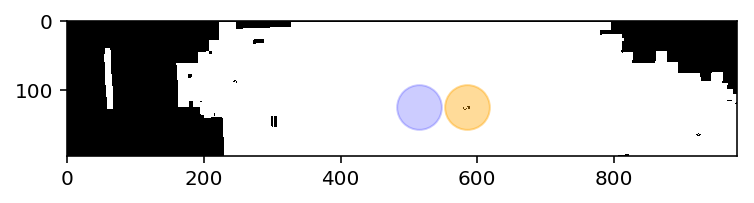

x = 564 @ Frame #120


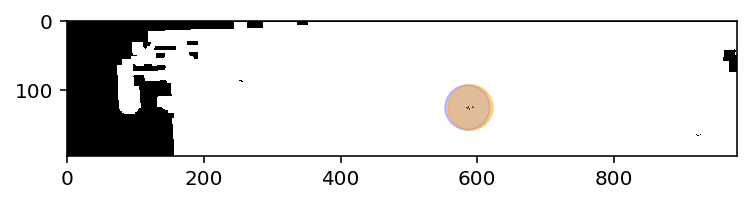

x = 554 @ Frame #180


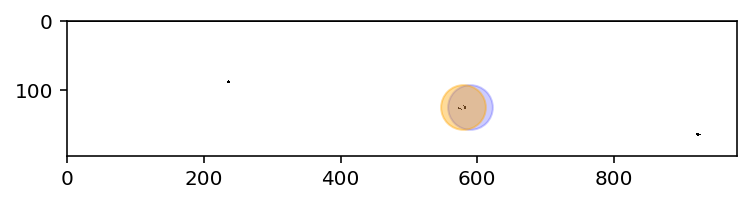

x = 540 @ Frame #240


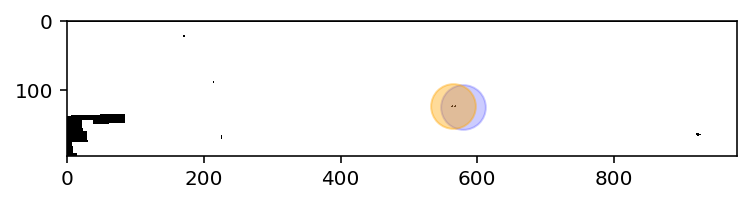

x = 554 @ Frame #300


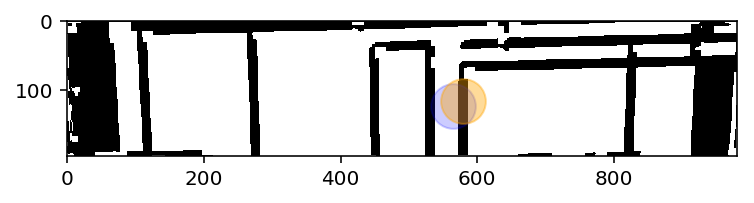

Processed 300 frames!


In [337]:
cap = cv2.VideoCapture(VidFile)

success,imageM = cap.read()

count = 0

xLog = np.array([x])

#while count < 6:

xO,yO,wO,hO = x,y,w,h

while(1):
        
    success,imageM = cap.read()
    
    if success:
        
    
        transformedM = perspective_transform(imageM, approx)
        rotatedM = 255 - imutils.rotate_bound(transformedM, angle=-90)

        # Tracking Happens Here

        hsvM = cv2.cvtColor(rotatedM, cv2.COLOR_BGR2HSV)

        dstM = cv2.calcBackProject([hsvM],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        retM, track_window = cv2.meanShift(dstM, track_window, term_crit)

        xM,yM,wM,hM = track_window

        xLog = np.append(xLog,xM)

        count += 1

        if count%60 == 0:
        
            plt.figure(dpi = 144)
            #plt.imshow(cv2.cvtColor(rotatedM, cv2.COLOR_BGR2RGB))
            plt.imshow(dstM, cmap = 'Greys')

            plt.scatter(xO + wO/2,yO + hO/2, s= 500, alpha = 0.2, color = 'blue')

            plt.scatter(xM + wM/2,yM + hM/2, s= 500, alpha = 0.4, color = 'orange')

            xO,yO,wO,hO = xM,yM,wM,hM
            print(f"x = {xM} @ Frame #{count}", end = '\n', flush = True)
        
            plt.show()


        
    else: 
        break
    
print(f"Processed {count} frames!")

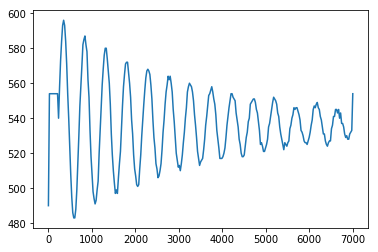

In [338]:
duration = 7000 # how many seconds is your experiment?

tLog = np.arange(count+1) / count * duration 

plt.plot(tLog, xLog)